In [1]:
!pip install --upgrade scikit-learn==1.0 --quiet

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # viz
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn import metrics, linear_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('labelled_training_data.csv')
test_df = pd.read_csv('labelled_testing_data.csv')
validation_df = pd.read_csv('labelled_validation_data.csv')

In [4]:
assert train_df.columns.all() == test_df.columns.all() == validation_df.columns.all()

In [5]:
train_df.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

In [6]:
train_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [7]:
train_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [8]:
train_df.head(2)

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0


In [9]:
train_df.describe(include=['object', 'float', 'int'])

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
count,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,7.631440e+05,763144,763144,763144.000000,763144,763144,763144.000000,763144.000000,763144,763144.000000,763144.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,36,8,NaN,32,97050,NaN,NaN,214720,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,ps,ubuntu,NaN,close,[],NaN,NaN,"[{'name': 'fd', 'type': 'int', 'value': 9}]",NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,406313,190500,NaN,218080,521115,NaN,NaN,107321,NaN,NaN
mean,1844.582673,6814.763308,6820.265241,1882.216609,2.279034,4.026532e+09,NaN,NaN,288.158953,NaN,NaN,2.672082,17.520924,NaN,0.001663,0.0
std,1136.638249,1948.871187,1937.068333,2215.563094,37.416576,1.649030e+02,NaN,NaN,385.117778,NaN,NaN,1.340906,318.596662,NaN,0.040744,0.0
min,132.560721,1.000000,1.000000,0.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,0.000000,-115.000000,NaN,0.000000,0.0
25%,903.250802,7313.000000,7313.000000,187.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,1.000000,0.000000,NaN,0.000000,0.0
50%,1829.203642,7365.000000,7365.000000,1385.000000,0.000000,4.026532e+09,NaN,NaN,62.000000,NaN,NaN,3.000000,0.000000,NaN,0.000000,0.0
75%,2761.380825,7415.000000,7415.000000,1648.000000,0.000000,4.026532e+09,NaN,NaN,257.000000,NaN,NaN,4.000000,4.000000,NaN,0.000000,0.0


<AxesSubplot:title={'center':'Label Frequency for evil label in Train Dataset'}>

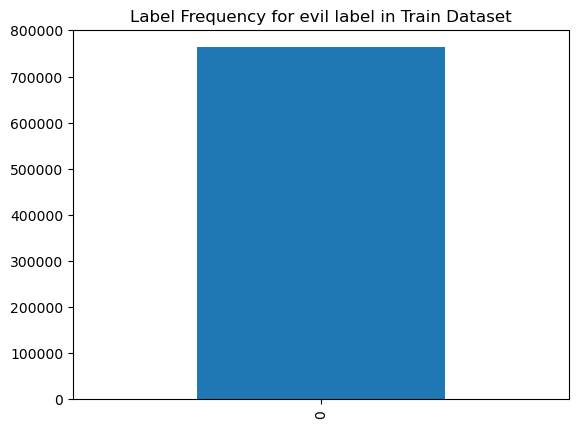

In [10]:
train_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Train Dataset')

In [11]:
test_df.groupby(['sus', 'evil'])[['timestamp']].count()

timestamp
sus evil           
0   0         17508
1   0         13027
    1        158432

In [12]:
test_df.loc[(test_df['sus'] == 1) & (test_df['evil'] == 1)].shape[0]

158432

In [13]:
def dataset_to_corr_heatmap(dataframe, title, ax):
    corr = dataframe.corr()
    sns.heatmap(corr, ax = ax, annot=True, cmap="YlGnBu")
    ax.set_title(f'Correlation Plot for {title}')

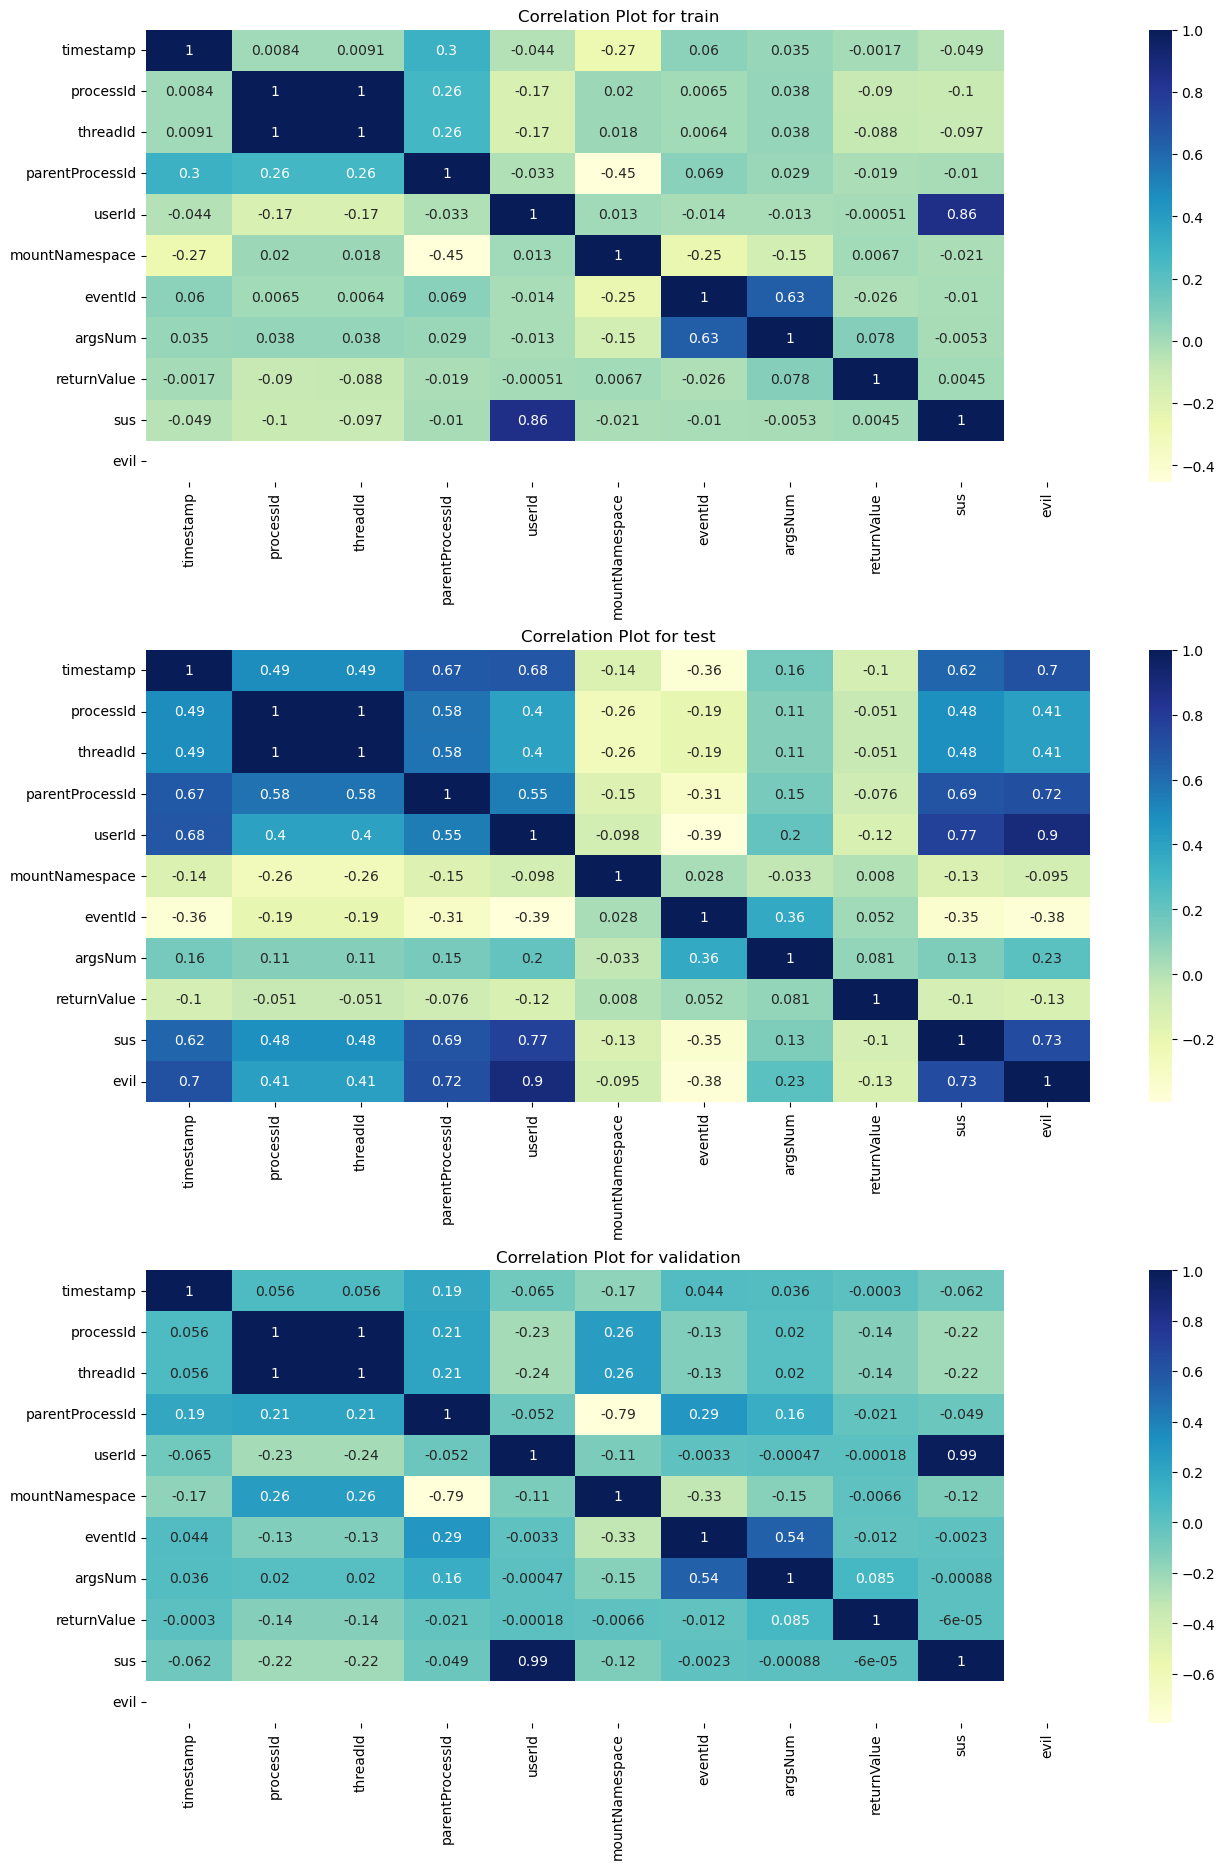

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,20))
fig.tight_layout(pad=10.0)
datasets = [train_df, test_df, validation_df]
dataset_names = ['train', 'test', 'validation']
axs = [ax1, ax2, ax3]

for dataset, name, ax in zip(datasets, dataset_names, axs):
    dataset_to_corr_heatmap(dataset, name, ax)

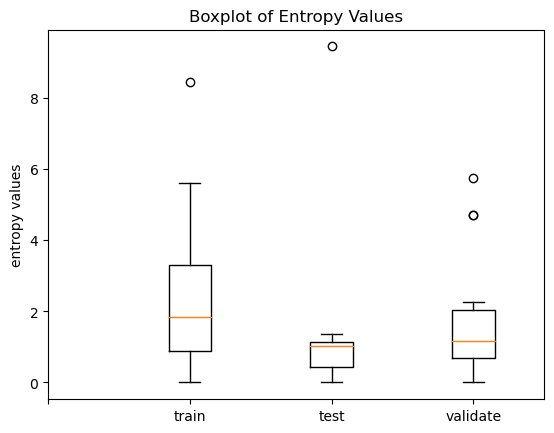

In [15]:
datasets = [train_df, test_df, validation_df]

entropy_values = []
for dataset in datasets:
    dataset_entropy_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_entropy = stats.entropy(counts)
            dataset_entropy_values.append(col_entropy)
            
    entropy_values.append(dataset_entropy_values)

plt.boxplot(entropy_values)
plt.title('Boxplot of Entropy Values')
plt.ylabel("entropy values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

In [16]:
def column_uniques(df, col):
    print(f'{col} - Uniques:\n\n{df[col].unique()} \n\nNo. Uniques: {df[col].nunique()}')

In [17]:
column_uniques(train_df, 'processName')

processName - Uniques:

['close' 'sh' 'run-parts' 'atd' 'systemd-logind' 'systemd'
 'systemd-journal' 'dbus-daemon' '(time-dir)' 'systemd-user-ru' 'docker'
 'systemd-resolve' 'dockerd' 'containerd-shim' 'amazon-ssm-agen' 'ps'
 'cron' 'snapd' 'systemd-network' 'journal-offline' 'kworker/dying'
 'ssm-agent-worke' 'packagekitd' 'gdbus' 'gmain' '(tmpfiles)'
 'systemd-tmpfile' 'kworker/u30:1' 'poweroff' '(sd-sync)' 'kworker/u30:0'
 'kworker/u30:2' 'systemd-timesyn' 'systemd-udevd' '(sd-pam)' 'sshd'] 

No. Uniques: 36


In [18]:
column_uniques(test_df, 'processName')

processName - Uniques:

['systemd-resolve' 'systemd-network' 'systemd' 'sshd' 'systemd-journal'
 'dbus-daemon' 'systemd-logind' 'docker' 'cron' '(sd-pam)' '(time-dir)'
 'systemd-user-ru' 'containerd-shim' 'amazon-ssm-agen' 'ps' 'snapd'
 'journal-offline' 'kworker/dying' 'ssm-agent-worke' 'packagekitd' 'gmain'
 'gdbus' '(systemd)' '(sd-executor)' '(direxec)' '30-systemd-envi'
 '(ystemctl)' 'systemctl' 'sh' 'env' 'run-parts' '00-header' 'uname'
 '10-help-text' '50-landscape-sy' 'grep' 'bc' 'cut' 'date'
 'landscape-sysin' 'who' '50-motd-news' 'cat' 'head' 'tr' '85-fwupd'
 '90-updates-avai' 'find' '91-release-upgr' 'lsb_release' 'id'
 'release-upgrade' 'stat' 'expr' '92-unattended-u' 'update-motd-una'
 '95-hwe-eol' 'update-motd-hwe' 'systemd-detect-' 'apt-config' 'dpkg'
 'dirname' 'mktemp' 'hwe-support-sta' 'mv' 'rm' '97-overlayroot' 'egrep'
 'sort' '98-fsck-at-rebo' 'update-motd-fsc' 'awk' '98-reboot-requi'
 'update-motd-reb' 'wc' 'bash' 'passwd' 'free' 'which' 'ls' 'crontab' 'w'
 'top' '

In [19]:
column_uniques(test_df, 'args')

args - Uniques:

["[{'name': 'domain', 'type': 'int', 'value': 'AF_UNIX'}, {'name': 'type', 'type': 'int', 'value': 'SOCK_DGRAM|SOCK_CLOEXEC'}, {'name': 'protocol', 'type': 'int', 'value': 0}]"
 "[{'name': 'pathname', 'type': 'const char*', 'value': '/proc/382/cgroup'}, {'name': 'flags', 'type': 'int', 'value': 'O_RDONLY|O_LARGEFILE'}, {'name': 'dev', 'type': 'dev_t', 'value': 5}, {'name': 'inode', 'type': 'unsigned long', 'value': 38584}]"
 "[{'name': 'dirfd', 'type': 'int', 'value': -100}, {'name': 'pathname', 'type': 'const char*', 'value': '/proc/382/cgroup'}, {'name': 'flags', 'type': 'int', 'value': 'O_RDONLY|O_CLOEXEC'}, {'name': 'mode', 'type': 'int', 'value': 3335958308}]"
 ...
 '[{\'name\': \'sockfd\', \'type\': \'int\', \'value\': 422}, {\'name\': \'addr\', \'type\': \'struct sockaddr*\', \'value\': "{\'sin_port\': \'22\',\'sin_addr\': \'192.168.31.56\',\'sa_family\': \'AF_INET\'}"}, {\'name\': \'addrlen\', \'type\': \'int\', \'value\': 16}]'
 '[{\'name\': \'sockfd\', \'type

In [20]:
column_uniques(train_df, 'args')

args - Uniques:

["[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NAME'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140662171848350}, {'name': 'arg5', 'type': 'unsigned long', 'value': 140662156379904}]"
 "[{'name': 'fd', 'type': 'int', 'value': 19}]" '[]' ...
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_SECCOMP'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 2}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94764243566176}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'unsigned long', 'value': 0}]"
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NO_NEW_PRIVS'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 1}, {'name': 'arg3', 'type': 'unsigned long', 'value': 0}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'u

In [21]:
sample = train_df['args'].sample(n=15, random_state=1)
sample

177122          [{'name': 'fd', 'type': 'int', 'value': 9}]
373280    [{'name': 'cap', 'type': 'int', 'value': 'CAP_...
308561    [{'name': 'dirfd', 'type': 'int', 'value': -10...
5304      [{'name': 'pathname', 'type': 'const char*', '...
443058    [{'name': 'pathname', 'type': 'const char*', '...
30792           [{'name': 'fd', 'type': 'int', 'value': 9}]
696842    [{'name': 'oldfd', 'type': 'int', 'value': 5},...
231563    [{'name': 'dirfd', 'type': 'int', 'value': -10...
596975    [{'name': 'fd', 'type': 'unsigned int', 'value...
194924    [{'name': 'pathname', 'type': 'const char*', '...
246369    [{'name': 'pathname', 'type': 'const char*', '...
749766    [{'name': 'dirfd', 'type': 'int', 'value': -10...
632617    [{'name': 'dirfd', 'type': 'int', 'value': 6},...
615272    [{'name': 'dirfd', 'type': 'int', 'value': 6},...
500954    [{'name': 'pathname', 'type': 'const char*', '...
Name: args, dtype: object

In [22]:
sample_df = pd.DataFrame(sample)
sample_df

,args
177122,"[{'name': 'fd', 'type': 'int', 'value': 9}]"
373280,"[{'name': 'cap', 'type': 'int', 'value': 'CAP_..."
308561,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
5304,"[{'name': 'pathname', 'type': 'const char*', '..."
443058,"[{'name': 'pathname', 'type': 'const char*', '..."
30792,"[{'name': 'fd', 'type': 'int', 'value': 9}]"
696842,"[{'name': 'oldfd', 'type': 'int', 'value': 5},..."
231563,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
596975,"[{'name': 'fd', 'type': 'unsigned int', 'value..."
194924,"[{'name': 'pathname', 'type': 'const char*', '..."


In [23]:
sample_df.iloc[0]

args    [{'name': 'fd', 'type': 'int', 'value': 9}]
Name: 177122, dtype: object

In [24]:
sample1 = sample_df.iloc[0]
sample1 = sample1.replace("[", "").replace("]", "").replace("'", '"')
sample1 = sample1[0]
sample1

"[{'name': 'fd', 'type': 'int', 'value': 9}]"

In [25]:
sample1 = json.dumps(sample1)
test1 = json.loads(sample1)

In [26]:
test1

"[{'name': 'fd', 'type': 'int', 'value': 9}]"

In [27]:
def strip_string(input_str):
    """
    Takes an input string and replaces specific
    puncutation marks with nothing
    
    Args:
        input_str: The string to be processed
    
    Returns:
        The processed string
    """
    assert isinstance(input_str, str)
    return input_str.replace("[", "").replace("]", "").replace("'", '"')

In [28]:
sample_df['stripped_args'] = sample_df['args'].apply(strip_string)

In [29]:
for i in sample_df['stripped_args']:
    print(i)
    print('\n')

{"name": "fd", "type": "int", "value": 9}


{"name": "cap", "type": "int", "value": "CAP_DAC_OVERRIDE"}


{"name": "dirfd", "type": "int", "value": -100}, {"name": "pathname", "type": "const char*", "value": "/proc/88/stat"}, {"name": "flags", "type": "unsigned long", "value": "O_RDONLY"}, {"name": "mode", "type": "int*", "value": 3849653931}


{"name": "pathname", "type": "const char*", "value": "/proc/7141"}, {"name": "statbuf", "type": "struct stat*", "value": "0x7F521D47F680"}


{"name": "pathname", "type": "const char*", "value": "/proc/7582/comm"}, {"name": "flags", "type": "int", "value": "O_RDONLY|O_LARGEFILE"}, {"name": "dev", "type": "dev_t", "value": 5}, {"name": "inode", "type": "unsigned long", "value": 46124}


{"name": "fd", "type": "int", "value": 9}


{"name": "oldfd", "type": "int", "value": 5}, {"name": "newfd", "type": "int", "value": 1}


{"name": "dirfd", "type": "int", "value": -100}, {"name": "pathname", "type": "const char*", "value": "/proc/22/stat"}, {"name":

In [30]:
sample_df['args'].iloc[2]

"[{'name': 'dirfd', 'type': 'int', 'value': -100}, {'name': 'pathname', 'type': 'const char*', 'value': '/proc/88/stat'}, {'name': 'flags', 'type': 'unsigned long', 'value': 'O_RDONLY'}, {'name': 'mode', 'type': 'int*', 'value': 3849653931}]"

In [31]:
test2 = sample_df['args'].iloc[2]

In [32]:
split_test2 = test2.split('},')
split_test2

["[{'name': 'dirfd', 'type': 'int', 'value': -100",
 " {'name': 'pathname', 'type': 'const char*', 'value': '/proc/88/stat'",
 " {'name': 'flags', 'type': 'unsigned long', 'value': 'O_RDONLY'",
 " {'name': 'mode', 'type': 'int*', 'value': 3849653931}]"]

In [33]:
strings = [string.replace("[", "").replace("]", "").replace("{", "").replace("'", "").replace("}", "").lstrip(" ") for string in split_test2]
strings

['name: dirfd, type: int, value: -100',
 'name: pathname, type: const char*, value: /proc/88/stat',
 'name: flags, type: unsigned long, value: O_RDONLY',
 'name: mode, type: int*, value: 3849653931']

In [34]:
list_of_lists = [item.split(',') for item in strings]
list_of_lists

[['name: dirfd', ' type: int', ' value: -100'],
 ['name: pathname', ' type: const char*', ' value: /proc/88/stat'],
 ['name: flags', ' type: unsigned long', ' value: O_RDONLY'],
 ['name: mode', ' type: int*', ' value: 3849653931']]

In [35]:
output = []
for lst in list_of_lists:
    for key_value in lst:
        key, value = key_value.split(': ', 1)
        if not output or key in output[-1]:
            output.append({})
        output[-1][key] = value

In [36]:
output

[{'name': 'dirfd', ' type': 'int', ' value': '-100'},
 {'name': 'pathname', ' type': 'const char*', ' value': '/proc/88/stat'},
 {'name': 'flags', ' type': 'unsigned long', ' value': 'O_RDONLY'},
 {'name': 'mode', ' type': 'int*', ' value': '3849653931'}]

In [37]:
json_output = json.dumps(output)

In [38]:
interim_df = pd.json_normalize(json.loads(json_output))
interim_df

,name,type,value
0,dirfd,int,-100
1,pathname,const char*,/proc/88/stat
2,flags,unsigned long,O_RDONLY
3,mode,int*,3849653931


In [39]:
interim_df.unstack()

name    0            dirfd
        1         pathname
        2            flags
        3             mode
 type   0              int
        1      const char*
        2    unsigned long
        3             int*
 value  0             -100
        1    /proc/88/stat
        2         O_RDONLY
        3       3849653931
dtype: object

In [40]:
interim_df.unstack().to_frame()

0
name   0          dirfd
       1       pathname
       2          flags
       3           mode
 type  0            int
       1    const char*
       2  unsigned long
       3           int*
 value 0           -100
       1  /proc/88/stat
       2       O_RDONLY
       3     3849653931

In [41]:
interim_df.unstack().to_frame().T

name                         type                                    \
       0         1      2     3     0            1              2     3   
0  dirfd  pathname  flags  mode   int  const char*  unsigned long  int*   

   value                                       
       0              1         2           3  
0   -100  /proc/88/stat  O_RDONLY  3849653931

In [42]:
interim_df.unstack().to_frame().T.sort_index(1,1)

,type,value,name,type,value,name,type,value,name,type,value,name
,0,0,0,1,1,1,2,2,2,3,3,3
0,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode


In [43]:
final_df = interim_df.unstack().to_frame().T.sort_index(1,1)
final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
final_df

,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode


In [44]:
def process_args_row(row):
    """
    Takes an single value from the 'args' column
    and returns a processed dataframe row
    
    Args:
        row: A single 'args' value/row
        
    Returns:
        final_df: The processed dataframe row
    """
    
    row = row.split('},')
    row = [string.replace("[", "").replace("]", "").replace("{", "").replace("'", "").replace("}", "").lstrip(" ") for string in row]
    row = [item.split(',') for item in row]
    
    processed_row = []
    for lst in row:
        for key_value in lst:
            key, value = key_value.split(': ', 1)
            if not processed_row or key in processed_row[-1]:
                processed_row.append({})
            processed_row[-1][key] = value
    
    json_row = json.dumps(processed_row)
    row_df = pd.json_normalize(json.loads(json_row))
    
    final_df = row_df.unstack().to_frame().T.sort_index(1,1)
    final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
    
    return final_df

In [45]:
data = sample_df['args'].tolist()

In [46]:
processed_dataframes = []

for row in data:
    ret = process_args_row(row)
    processed_dataframes.append(ret)

In [47]:
processed = pd.concat(processed_dataframes).reset_index(drop=True)
processed.columns = processed.columns.str.lstrip()
processed

,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,int,CAP_DAC_OVERRIDE,cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode
3,const char*,/proc/7141,pathname,struct stat*,0x7F521D47F680,statbuf,NaN,NaN,NaN,NaN,NaN,NaN
4,const char*,/proc/7582/comm,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,46124,inode
5,int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,int,5,oldfd,int,1,newfd,NaN,NaN,NaN,NaN,NaN,NaN
7,int,-100,dirfd,const char*,/proc/22/stat,pathname,int,O_RDONLY,flags,mode_t,1532681899,mode
8,unsigned int,16,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,const char*,/proc/504/status,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,38957,inode


In [48]:
sample_df = sample_df.reset_index(drop=True)
merged_sample = pd.concat([sample_df, processed], axis=1)
merged_sample

,args,stripped_args,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,"[{'name': 'fd', 'type': 'int', 'value': 9}]","{""name"": ""fd"", ""type"": ""int"", ""value"": 9}",int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'name': 'cap', 'type': 'int', 'value': 'CAP_...","{""name"": ""cap"", ""type"": ""int"", ""value"": ""CAP_D...",int,CAP_DAC_OVERRIDE,cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'name': 'dirfd', 'type': 'int', 'value': -10...","{""name"": ""dirfd"", ""type"": ""int"", ""value"": -100...",int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode
3,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/7141,pathname,struct stat*,0x7F521D47F680,statbuf,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/7582/comm,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,46124,inode
5,"[{'name': 'fd', 'type': 'int', 'value': 9}]","{""name"": ""fd"", ""type"": ""int"", ""value"": 9}",int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"[{'name': 'oldfd', 'type': 'int', 'value': 5},...","{""name"": ""oldfd"", ""type"": ""int"", ""value"": 5}, ...",int,5,oldfd,int,1,newfd,NaN,NaN,NaN,NaN,NaN,NaN
7,"[{'name': 'dirfd', 'type': 'int', 'value': -10...","{""name"": ""dirfd"", ""type"": ""int"", ""value"": -100...",int,-100,dirfd,const char*,/proc/22/stat,pathname,int,O_RDONLY,flags,mode_t,1532681899,mode
8,"[{'name': 'fd', 'type': 'unsigned int', 'value...","{""name"": ""fd"", ""type"": ""unsigned int"", ""value""...",unsigned int,16,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/504/status,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,38957,inode


In [49]:
# Taken from here - https://github.com/jinxmirror13/BETH_Dataset_Analysis
train_df["processId"] = train_df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["parentProcessId"] = train_df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["userId"] = train_df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_df["mountNamespace"] = train_df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_df["eventId"] = train_df["eventId"]  # Keep eventId values (requires knowing max value)
train_df["returnValue"] = train_df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error

In [50]:
train_df.head(5)

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,1,7337,0,0,1,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,1,7337,0,0,1,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,1,7337,0,0,1,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,1,7347,1,0,0,sh,ip-10-100-1-120,21,access,[],2,2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,1,7347,1,0,0,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [51]:
train = train_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
train_labels = train_df['sus']

In [52]:
train.head(5)

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,1,0,0,1,157,5,0
1,1,0,0,1,3,1,0
2,1,0,0,1,1010,0,0
3,1,1,0,0,21,2,2
4,1,1,0,0,1005,4,0


In [53]:
train_labels

0         1
1         1
2         1
3         1
4         1
         ..
763139    0
763140    0
763141    0
763142    0
763143    0
Name: sus, Length: 763144, dtype: int64

In [54]:
assert len(train_labels) == train.shape[0]

In [55]:
def process_args_dataframe(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Processes the `args` column within the dataset
    """
    
    processed_dataframes = []
    data = df[column_name].tolist()
    
    # Debug counter
    counter = 0
    
    for row in data:
        if row == '[]': # If there are no args
            pass
        else:
            try:
                ret = process_args_row(row)
                processed_dataframes.append(ret)
            except:
                print(f'Error Encounter: Row {counter} - {row}')

            counter+=1
        
    processed = pd.concat(processed_dataframes).reset_index(drop=True)
    processed.columns = processed.columns.str.lstrip()
    
    df = pd.concat([df, processed], axis=1)
    
    return df

def prepare_dataset(df: pd.DataFrame, process_args=False) -> pd.DataFrame:
    """
    Prepare the dataset by completing the standard feature engineering tasks
    """
    
    df["processId"] = train_df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["parentProcessId"] = train_df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["userId"] = train_df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
    df["mountNamespace"] = train_df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
    df["eventId"] = train_df["eventId"]  # Keep eventId values (requires knowing max value)
    df["returnValue"] = train_df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error
    
    if process_args is True:
        df = process_args_dataframe(df, 'args')
        
    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
    labels = df['sus']
        
    return features, labels

In [56]:
train_no_args_feats, train_no_args_labels = prepare_dataset(train_df)

In [57]:
train_no_args_feats.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,0,0,0,1,157,5,0
1,0,0,0,1,3,1,0
2,0,0,0,1,1010,0,0
3,0,0,0,1,21,2,1
4,0,0,0,1,1005,4,0


In [58]:
train_no_args_labels.head()

0    1
1    1
2    1
3    1
4    1
Name: sus, dtype: int64